In [1]:
%matplotlib inline

In [2]:
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import lmfit as lf

from scipy.stats import norm

# functions written for this project
import utils
import two_stage_model as model

### Orientation Suppression

In [3]:
os_df = utils.load_all_data("cleanData/*filteredData_OS.mat", utils.load_individual_os_data)

In [4]:
# Since -1 and -2 represent baseline, these should both be true
print(np.all(os_df[os_df.Orientation==-1]['MaskContrast']==0))
print(np.all(os_df[os_df.Orientation==-2]['MaskContrast']==0))

True
True


In [5]:
os_df.head(n=5)

,Subject,StaircaseNumber,Eye,Orientation,Presentation,MaskContrast,TrialNumberStaircase,ProbeContrastRecommended,ResponseAccuracy,ProbeContrastUsed,ProbeInterval,FileNumber
223,cr,1,2,90,2,79.0,0,99.0,1,99.0,1,2
224,cr,2,2,90,2,62.0,0,99.0,1,99.0,2,2
225,cr,3,2,90,2,50.0,0,99.0,1,99.0,2,2
226,cr,1,2,90,2,79.0,1,79.0,1,79.0,2,2
227,cr,3,2,90,2,50.0,1,50.0,0,50.0,1,2


In [6]:
gvars = ["Subject", "Eye", "Orientation", "Presentation"] # Presentation conditions
gvars_mask = gvars + ["MaskContrast"] # Mask contrast, m in the model
gvars_masktarget = gvars_mask + ["ProbeContrastUsed"] # Target contrast, t in the model

In [7]:
grouped, condensed_df = utils.summarize_conditions(os_df, gvars_masktarget)

In [8]:
df = condensed_df.reset_index()
df.head(n=10)

,Subject,Eye,Orientation,Presentation,MaskContrast,ProbeContrastUsed,n,c,pct_correct
0,ah,1,0,1,11.0,0.82,2,1,0.500000
1,ah,1,0,1,11.0,1.10,3,2,0.666667
2,ah,1,0,1,11.0,1.47,7,3,0.428571
3,ah,1,0,1,11.0,1.96,15,11,0.733333
4,ah,1,0,1,11.0,2.61,19,12,0.631579
5,ah,1,0,1,11.0,3.48,26,22,0.846154
6,ah,1,0,1,11.0,4.64,24,16,0.666667
7,ah,1,0,1,11.0,6.19,32,25,0.781250
8,ah,1,0,1,11.0,8.25,26,24,0.923077
9,ah,1,0,1,11.0,11.00,22,21,0.954545


#### Develop a function that should be minimized to fit the model

Within each staircase, you have numerous trials at different MaskContrasts, and as outcomes you have ResponseAccuracy (0|1). In the paper they describe these as the number of trials (n) and correct responses (c) for each target (here, ProbeContrastUsed) and mask (MaskContrast) level.

Ultimately, they fit their parameters (p, q, z, sigma_int - but mine will be different since i'm using a different model) by minimizing a likelihood function of these parameters given (vectors) m, t, n, c which are the different mask/target conditions.

Questions:
 * what are the parameters of the two-stage model, and which of those are going to be fixed and which are going to be free to vary, ie fit?
 * What is this normal integral d' to percent correct (P(c)) transformation?
     * Phi(t) is the cdf of the normal distribution, tells you the probability that the normal variable is less than t
 * What is the proper equation for the likelihood of the parameters given m, t, n, and c?
 * What is the proper function for calculating percent correct from the model parameters?

In [9]:
params = lf.Parameters()
params.add('m', value=1.3, vary=False)
params.add('S', value=1, vary=False)
params.add('w_m', value=1, min=0.0, vary=True)
params.add('w_d', value=1, min=0.0, vary=True)
params.add('a', value=0, min=0.0, vary=True)
params.add('k', value=0.2, vary=False)
params.add('p', value=8, vary=False)
params.add('q', value=6.5, vary=False)
params.add('Z', value=.0085, vary=False)

In [10]:
fitted_params = df.groupby(gvars).apply(utils.model_condition, model.two_stage_response, params)

('ah', 1, 0, 1) 54
('ah', 1, 0, 1) 54
('ah', 1, 0, 2) 35
('ah', 1, 90, 1) 53
('ah', 1, 90, 2) 49
('ah', 2, 0, 1) 56
('ah', 2, 0, 2) 63
('ah', 2, 90, 1) 55
('ah', 2, 90, 2) 62
('ai', 1, 0, 1) 41
('ai', 1, 0, 2) 47
('ai', 1, 90, 1) 30
('ai', 1, 90, 2) 37
('ai', 2, 0, 1) 32
('ai', 2, 0, 2) 37
('ai', 2, 90, 1) 23
('ai', 2, 90, 2) 30
('am', 1, 0, 1) 59
('am', 1, 0, 2) 51
('am', 1, 90, 1) 53
('am', 1, 90, 2) 95
('am', 2, 0, 1) 58
('am', 2, 0, 2) 76
('am', 2, 90, 1) 53
('am', 2, 90, 2) 70
('ap', 2, 0, 1) 53
('ap', 2, 0, 2) 38
('ap', 2, 90, 1) 51
('ap', 2, 90, 2) 41
('bi', 1, 0, 1) 37
('bi', 1, 0, 2) 30
('bi', 1, 90, 1) 36
('bi', 1, 90, 2) 36
('bi', 2, 0, 1) 34
('bi', 2, 0, 2) 37
('bi', 2, 90, 1) 26
('bi', 2, 90, 2) 37
('bo', 1, 0, 1) 52
('bo', 1, 0, 2) 59
('bo', 1, 90, 1) 49
('bo', 1, 90, 2) 51
('cl', 1, 0, 1) 26
('cl', 1, 0, 2) 43
('cl', 1, 90, 1) 28
('cl', 1, 90, 2) 34
('cl', 2, 0, 1) 28
('cl', 2, 0, 2) 47
('cl', 2, 90, 1) 31
('cl', 2, 90, 2) 41
('cr', 2, 0, 1) 55
('cr', 2, 0, 2) 31
('cr', 

In [11]:
fitted_df = fitted_params.reset_index()

In [12]:
fitted_df

,Subject,Eye,Orientation,Presentation,m,S,w_m,w_d,a,k,p,q,Z
0,ah,1,0,1,1.3,1.0,5.103887e-01,1.000000,0.0,0.2,8.0,6.5,0.0085
1,ah,1,0,2,1.3,1.0,1.000000e+00,1.014628,0.0,0.2,8.0,6.5,0.0085
2,ah,1,90,1,1.3,1.0,1.781781e-01,1.000000,0.0,0.2,8.0,6.5,0.0085
3,ah,1,90,2,1.3,1.0,1.000000e+00,0.279755,0.0,0.2,8.0,6.5,0.0085
4,ah,2,0,1,1.3,1.0,9.039280e-03,1.000000,0.0,0.2,8.0,6.5,0.0085
5,ah,2,0,2,1.3,1.0,1.000000e+00,1.076079,0.0,0.2,8.0,6.5,0.0085
6,ah,2,90,1,1.3,1.0,7.146651e+01,1.000000,0.0,0.2,8.0,6.5,0.0085
7,ah,2,90,2,1.3,1.0,1.000000e+00,1.107484,0.0,0.2,8.0,6.5,0.0085
8,ai,1,0,1,1.3,1.0,1.010466e+00,1.000000,0.0,0.2,8.0,6.5,0.0085
9,ai,1,0,2,1.3,1.0,1.000000e+00,1.058050,0.0,0.2,8.0,6.5,0.0085


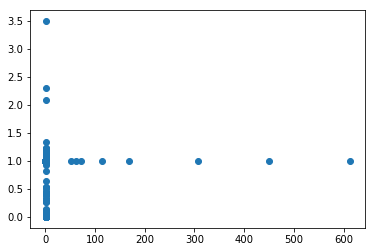

In [13]:
plt.scatter(fitted_df['w_m'], fitted_df['w_d'])

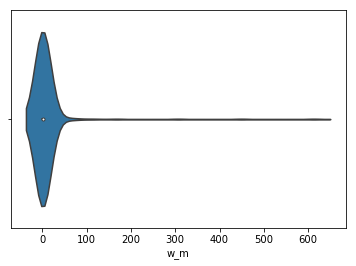

In [14]:
sns.violinplot(fitted_df['w_m'])

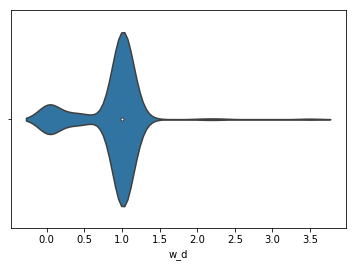

In [15]:
sns.violinplot(fitted_df['w_d'])

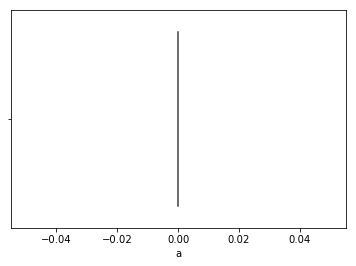

In [16]:
sns.violinplot(fitted_df['a'])

### Surround Suppression

In [17]:
ss_df = utils.load_all_data("cleanData/*filteredData_SS.mat", utils.load_individual_ss_data)

Testing LL

In [18]:
model.loglikelihood(10, 4, .5)

-0.20135513550688877

In [19]:
!pytest test_utils.py

============================= test session starts ==============================
platform darwin -- Python 3.6.2, pytest-3.2.1, py-1.4.34, pluggy-0.4.0
rootdir: /Users/smerdis/code/ay250-hw/final_project, inifile:
plugins: cov-2.5.1
collected 1 item                                                                

test_utils.py F

=================================== FAILURES ===================================
___________________________ TestUtils.test_fileload ____________________________

self = <test_utils.TestUtils testMethod=test_fileload>

    def test_fileload(self):
        os_data_file = "cleanData/ah_filteredData_OS.mat"
        os_df = utils.load_individual_os_data(os_data_file)
>       self.assertTrue(np.all(os_df[os_df.Orientation==-1]['MaskContrast']==0))
E       NameError: name 'np' is not defined

test_utils.py:11: NameError
=========================== 1 failed in 1.98 seconds ===========================
